# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [50]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

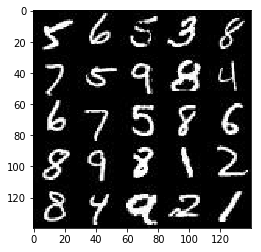

In [51]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

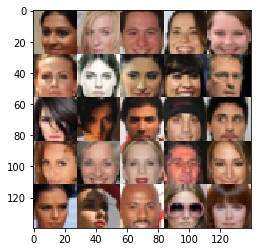

In [52]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [53]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [85]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_ = tf.placeholder(
        tf.float32,
        shape=[
            None,
            image_width,
            image_height,
            image_channels
        ],
        name='real_inputs'
    )
    z_inputs_ = tf.placeholder(
        tf.float32,
        shape=[None, z_dim],
        name='z_inputs'
    )
    learning_rate = tf.placeholder(
        tf.float32,
        name='learning_rate'
    )

    return (inputs_, z_inputs_, learning_rate)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [86]:
import numpy as np

def lrelu(x, alpha=0.1):
    return tf.maximum(alpha * x, x)

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        lrelu1 = lrelu(conv1)
        # 14x14x64

        conv2 = tf.layers.conv2d(lrelu1, 128, 5, strides=2, padding='same')
        bnconv2 = tf.layers.batch_normalization(conv2, training=True)
        lrelu2 = lrelu(bnconv2)
        # 7x7x128
        
        conv3 = tf.layers.conv2d(lrelu2, 256, 5, strides=2, padding='same')
        bnconv3 = tf.layers.batch_normalization(conv3, training=True)
        lrelu3 = lrelu(bnconv3)
        # 4x4x256

        conv4 = tf.layers.conv2d(lrelu3, 512, 5, strides=2, padding='same')
        bnconv4 = tf.layers.batch_normalization(conv4, training=True)
        lrelu4 = lrelu(bnconv4)
        # 2x2x512

        dim = np.product(
            lrelu3.get_shape().as_list()[1:]
        )
        flat = tf.reshape(lrelu3, (-1, dim))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [87]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        h1 = tf.layers.dense(z, 7*7*512)
        h1 = tf.reshape(h1, (-1, 7, 7, 512))
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        h1 = lrelu(h1)

        h2 = tf.layers.conv2d_transpose(h1, 256, 5, strides=2, padding='same')
        h2 = tf.layers.batch_normalization(h2, training=is_train)
        h2 = lrelu(h2)
        # 14x14x256
        
        h3 = tf.layers.conv2d_transpose(h2, 512, 5, strides=2, padding='same')
        h3 = tf.layers.batch_normalization(h3, training=is_train)
        h3 = lrelu(h3)
        # 28x28x512

        h4 = tf.layers.conv2d_transpose(h3, 1024, 5, strides=1, padding='same')
        h4 = tf.layers.batch_normalization(h4, training=is_train)
        h4 = lrelu(h3)
        # 28x28x1024
        
        logits = tf.layers.conv2d(h3, out_channel_dim, 5, strides=1, padding='same')

        return tf.tanh(logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [88]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(
        input_z,
        out_channel_dim
    )
    
    d_model_real, d_logits_real = discriminator(
        input_real,
        reuse=False
    )
    
    d_model_fake, d_logits_fake = discriminator(
        g_model,
        reuse=True
    )

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_real,
            labels=tf.ones_like(d_model_real)
        )
    )

    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake,
            labels=tf.zeros_like(d_model_fake)
        )
    )

    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake,
            labels=tf.ones_like(d_model_fake)
        )
    )

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [79]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    vs = tf.trainable_variables()
    d_vars = [v for v in vs if v.name.startswith('discriminator')]
    g_vars = [v for v in vs if v.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(
            learning_rate,
            beta1=beta1
        ).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(
            learning_rate,
            beta1=beta1
        ).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [80]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [89]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))

    image_width, image_height, image_channels = data_shape[1:]

    input_real, input_z, lr = model_inputs(
        image_width, image_height, image_channels, z_dim
    )

    d_loss, g_loss = model_loss(
        input_real, input_z, image_channels
    )

    d_opt, g_opt = model_opt(
        d_loss, g_loss, learning_rate, 0.5
    )

    steps = 0
    show_every = 100
    print_every = 25
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1

                batch_images *= 2
                batch_z = np.random.uniform(
                    -1,
                    1,
                    size=(batch_size, z_dim)
                )

                sess.run(d_opt, feed_dict={
                    input_real: batch_images,
                    input_z: batch_z
                })

                sess.run(g_opt, feed_dict={
                    input_real: batch_images,
                    input_z: batch_z
                })

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({
                        input_z: batch_z,
                        input_real: batch_images
                    })
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{},".format(epoch_i + 1, epoch_count),
                          "Discriminator Loss: {:.4f},".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % show_every == 0:
                    gen_samples = sess.run(
                        generator(
                            input_z,
                            image_channels,
                            False
                        ),
                        feed_dict={
                            input_z: batch_z
                        }
                    )

                    show_generator_output(
                        sess,
                        12,
                        input_z,
                        image_channels,
                        data_image_mode
                    )

        print('Result after training:')
        gen_samples = sess.run(
            generator(
                input_z,
                image_channels,
                False
            ),
            feed_dict={
                input_z: batch_z
            }
        )

        show_generator_output(
            sess,
            12,
            input_z,
            image_channels,
            data_image_mode
        )

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2, Discriminator Loss: 0.6788, Generator Loss: 0.9846
Epoch 1/2, Discriminator Loss: 0.6749, Generator Loss: 1.7364
Epoch 1/2, Discriminator Loss: 0.8505, Generator Loss: 1.0461
Epoch 1/2, Discriminator Loss: 1.3376, Generator Loss: 0.7838


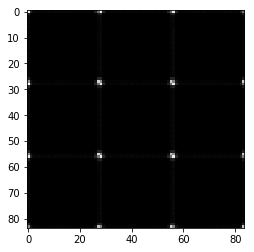

Epoch 1/2, Discriminator Loss: 1.2784, Generator Loss: 0.6732
Epoch 1/2, Discriminator Loss: 1.1881, Generator Loss: 0.7383
Epoch 1/2, Discriminator Loss: 1.0268, Generator Loss: 0.9883
Epoch 1/2, Discriminator Loss: 1.0010, Generator Loss: 0.7264


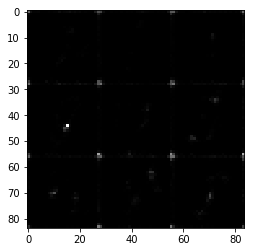

Epoch 1/2, Discriminator Loss: 0.9455, Generator Loss: 1.0445
Epoch 1/2, Discriminator Loss: 0.8011, Generator Loss: 1.1921
Epoch 1/2, Discriminator Loss: 0.7797, Generator Loss: 1.0011
Epoch 1/2, Discriminator Loss: 0.8948, Generator Loss: 1.1434


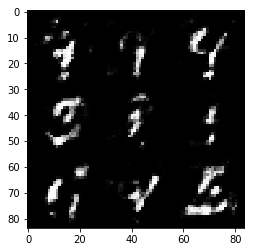

Epoch 1/2, Discriminator Loss: 0.5004, Generator Loss: 2.1941
Epoch 1/2, Discriminator Loss: 0.9036, Generator Loss: 0.7735
Epoch 1/2, Discriminator Loss: 0.9413, Generator Loss: 0.8174
Epoch 1/2, Discriminator Loss: 0.8196, Generator Loss: 1.2221


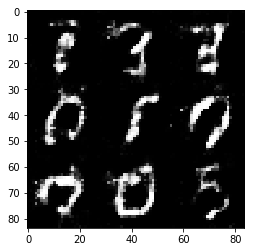

Epoch 1/2, Discriminator Loss: 0.9511, Generator Loss: 0.8655
Epoch 1/2, Discriminator Loss: 1.4394, Generator Loss: 0.4176
Epoch 1/2, Discriminator Loss: 0.7271, Generator Loss: 1.4653
Epoch 1/2, Discriminator Loss: 1.1424, Generator Loss: 1.7802


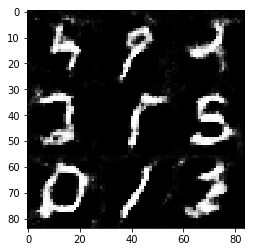

Epoch 1/2, Discriminator Loss: 1.0323, Generator Loss: 0.7029
Epoch 1/2, Discriminator Loss: 1.0480, Generator Loss: 0.7800
Epoch 1/2, Discriminator Loss: 1.1300, Generator Loss: 0.5686
Epoch 1/2, Discriminator Loss: 0.9927, Generator Loss: 0.9128


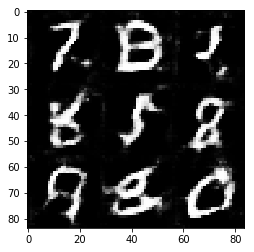

Epoch 1/2, Discriminator Loss: 0.9326, Generator Loss: 1.5664
Epoch 1/2, Discriminator Loss: 1.1221, Generator Loss: 0.5521
Epoch 1/2, Discriminator Loss: 1.1817, Generator Loss: 0.5298
Epoch 1/2, Discriminator Loss: 0.8704, Generator Loss: 1.1373


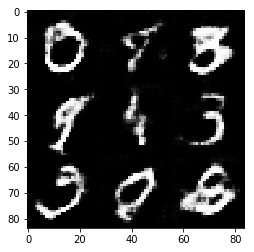

Epoch 1/2, Discriminator Loss: 1.2410, Generator Loss: 0.4912
Epoch 1/2, Discriminator Loss: 0.9671, Generator Loss: 0.7970
Epoch 1/2, Discriminator Loss: 0.8471, Generator Loss: 0.9978
Epoch 1/2, Discriminator Loss: 1.0929, Generator Loss: 0.7205


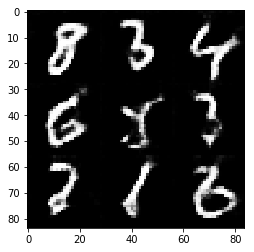

Epoch 1/2, Discriminator Loss: 0.9194, Generator Loss: 0.7734
Epoch 1/2, Discriminator Loss: 1.0819, Generator Loss: 0.8247
Epoch 1/2, Discriminator Loss: 1.1135, Generator Loss: 0.5991
Epoch 1/2, Discriminator Loss: 0.7769, Generator Loss: 1.0253


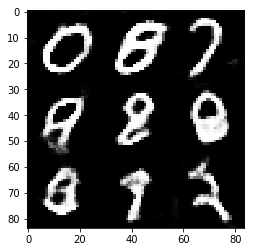

Epoch 1/2, Discriminator Loss: 0.7565, Generator Loss: 1.8143
Epoch 2/2, Discriminator Loss: 0.8782, Generator Loss: 1.1972
Epoch 2/2, Discriminator Loss: 0.9017, Generator Loss: 0.9318
Epoch 2/2, Discriminator Loss: 1.1541, Generator Loss: 0.5675


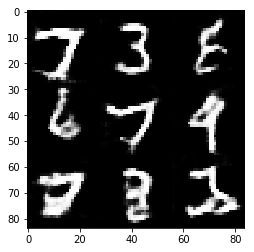

Epoch 2/2, Discriminator Loss: 0.9289, Generator Loss: 0.7740
Epoch 2/2, Discriminator Loss: 0.8590, Generator Loss: 0.7942
Epoch 2/2, Discriminator Loss: 0.7286, Generator Loss: 1.0313
Epoch 2/2, Discriminator Loss: 0.8686, Generator Loss: 0.8023


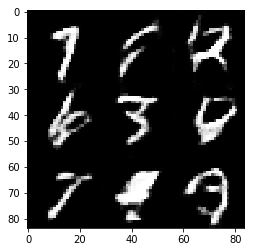

Epoch 2/2, Discriminator Loss: 0.7897, Generator Loss: 1.0556
Epoch 2/2, Discriminator Loss: 1.2558, Generator Loss: 0.4452
Epoch 2/2, Discriminator Loss: 0.9315, Generator Loss: 0.7459
Epoch 2/2, Discriminator Loss: 0.9196, Generator Loss: 0.7160


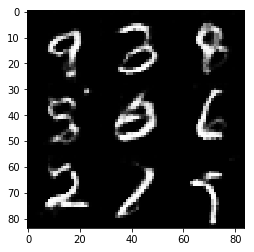

Epoch 2/2, Discriminator Loss: 0.7661, Generator Loss: 0.9873
Epoch 2/2, Discriminator Loss: 0.7574, Generator Loss: 1.1115
Epoch 2/2, Discriminator Loss: 0.6848, Generator Loss: 1.4401
Epoch 2/2, Discriminator Loss: 0.5167, Generator Loss: 1.4337


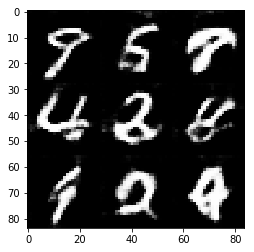

Epoch 2/2, Discriminator Loss: 0.8847, Generator Loss: 1.6391
Epoch 2/2, Discriminator Loss: 0.8478, Generator Loss: 1.2472
Epoch 2/2, Discriminator Loss: 0.7814, Generator Loss: 1.0050
Epoch 2/2, Discriminator Loss: 0.8311, Generator Loss: 1.5439


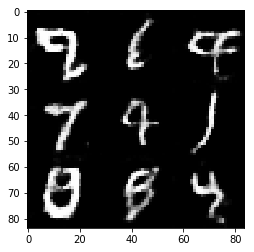

Epoch 2/2, Discriminator Loss: 0.8408, Generator Loss: 0.9000
Epoch 2/2, Discriminator Loss: 1.2410, Generator Loss: 0.5139
Epoch 2/2, Discriminator Loss: 1.2332, Generator Loss: 0.4826
Epoch 2/2, Discriminator Loss: 1.1079, Generator Loss: 0.5979


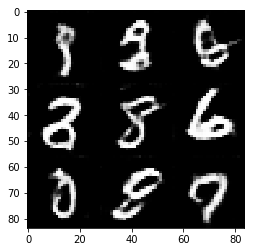

Epoch 2/2, Discriminator Loss: 0.9556, Generator Loss: 0.9114
Epoch 2/2, Discriminator Loss: 0.9224, Generator Loss: 1.1280
Epoch 2/2, Discriminator Loss: 1.2588, Generator Loss: 0.4648
Epoch 2/2, Discriminator Loss: 0.6623, Generator Loss: 1.3225


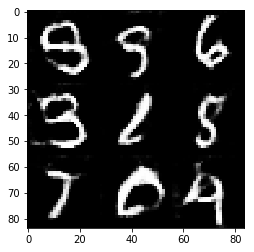

Epoch 2/2, Discriminator Loss: 1.2445, Generator Loss: 0.4561
Epoch 2/2, Discriminator Loss: 0.6721, Generator Loss: 1.5274
Epoch 2/2, Discriminator Loss: 0.7192, Generator Loss: 1.6332
Epoch 2/2, Discriminator Loss: 0.9897, Generator Loss: 0.6815


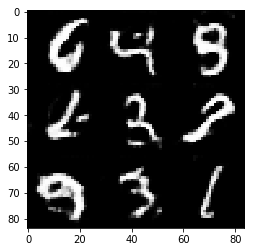

Epoch 2/2, Discriminator Loss: 0.6284, Generator Loss: 1.5222
Epoch 2/2, Discriminator Loss: 0.8312, Generator Loss: 0.9850
Epoch 2/2, Discriminator Loss: 0.6605, Generator Loss: 1.4987
Epoch 2/2, Discriminator Loss: 0.7106, Generator Loss: 1.9996


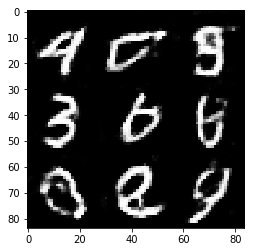

Epoch 2/2, Discriminator Loss: 0.7895, Generator Loss: 1.0631
Epoch 2/2, Discriminator Loss: 1.2444, Generator Loss: 0.4462
Result after training:


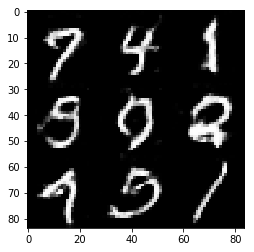

In [90]:
batch_size = 128
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5

batch_size = 256
z_dim = 128
learning_rate = 0.0001
beta1 = 0.2

batch_size = 64
z_dim = 128
learning_rate = 0.0002
beta1 = 0.1

batch_size = 64
z_dim = 128
learning_rate = 0.0001
beta1 = 0.1

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1, Discriminator Loss: 0.5603, Generator Loss: 1.2398
Epoch 1/1, Discriminator Loss: 0.6138, Generator Loss: 1.7590
Epoch 1/1, Discriminator Loss: 0.4051, Generator Loss: 1.8899
Epoch 1/1, Discriminator Loss: 0.4186, Generator Loss: 1.7778


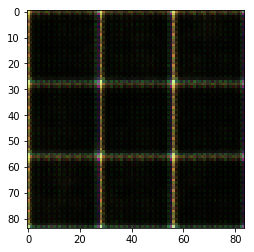

Epoch 1/1, Discriminator Loss: 0.3784, Generator Loss: 1.4701
Epoch 1/1, Discriminator Loss: 0.3059, Generator Loss: 1.7941
Epoch 1/1, Discriminator Loss: 1.0315, Generator Loss: 0.5770
Epoch 1/1, Discriminator Loss: 0.3507, Generator Loss: 2.2518


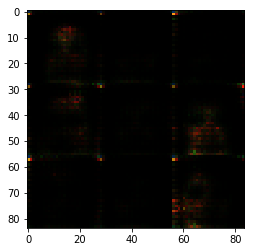

Epoch 1/1, Discriminator Loss: 0.1290, Generator Loss: 3.9083
Epoch 1/1, Discriminator Loss: 0.5518, Generator Loss: 5.5880
Epoch 1/1, Discriminator Loss: 1.4505, Generator Loss: 0.4122
Epoch 1/1, Discriminator Loss: 0.1438, Generator Loss: 3.6984


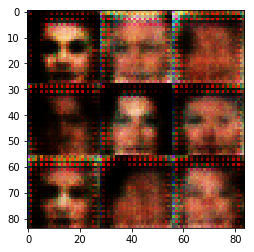

Epoch 1/1, Discriminator Loss: 0.2349, Generator Loss: 2.2759
Epoch 1/1, Discriminator Loss: 0.4069, Generator Loss: 1.8059
Epoch 1/1, Discriminator Loss: 0.4006, Generator Loss: 1.8404
Epoch 1/1, Discriminator Loss: 1.4619, Generator Loss: 0.4160


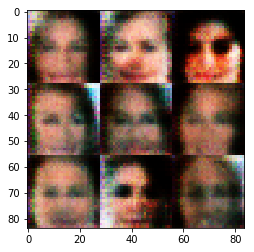

Epoch 1/1, Discriminator Loss: 0.2938, Generator Loss: 3.0442
Epoch 1/1, Discriminator Loss: 0.4319, Generator Loss: 1.8630
Epoch 1/1, Discriminator Loss: 0.5029, Generator Loss: 1.3954
Epoch 1/1, Discriminator Loss: 0.3062, Generator Loss: 3.7603


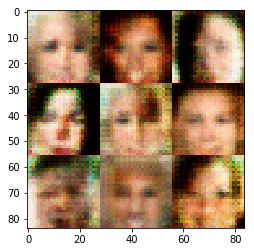

Epoch 1/1, Discriminator Loss: 1.0400, Generator Loss: 0.6466
Epoch 1/1, Discriminator Loss: 0.9144, Generator Loss: 0.7250
Epoch 1/1, Discriminator Loss: 0.3362, Generator Loss: 3.7420
Epoch 1/1, Discriminator Loss: 0.1543, Generator Loss: 4.7221


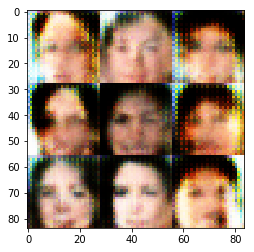

Epoch 1/1, Discriminator Loss: 0.5852, Generator Loss: 1.0984
Epoch 1/1, Discriminator Loss: 0.2574, Generator Loss: 2.1942
Epoch 1/1, Discriminator Loss: 0.2367, Generator Loss: 4.0500
Epoch 1/1, Discriminator Loss: 0.0917, Generator Loss: 3.0336


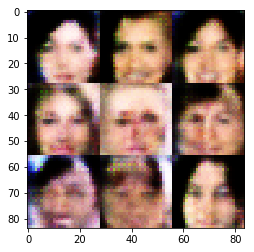

Epoch 1/1, Discriminator Loss: 0.9491, Generator Loss: 0.6162
Epoch 1/1, Discriminator Loss: 0.9001, Generator Loss: 0.6816
Epoch 1/1, Discriminator Loss: 0.3598, Generator Loss: 1.6308
Epoch 1/1, Discriminator Loss: 0.2361, Generator Loss: 2.1475


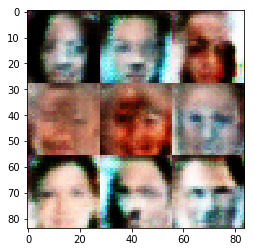

Epoch 1/1, Discriminator Loss: 0.0804, Generator Loss: 5.6066
Epoch 1/1, Discriminator Loss: 0.0615, Generator Loss: 4.9675
Epoch 1/1, Discriminator Loss: 0.2834, Generator Loss: 1.9388
Epoch 1/1, Discriminator Loss: 0.4434, Generator Loss: 2.7436


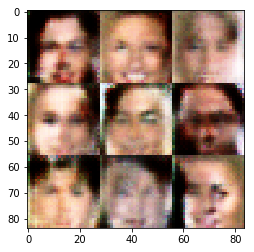

Epoch 1/1, Discriminator Loss: 0.1463, Generator Loss: 9.7485
Epoch 1/1, Discriminator Loss: 1.3569, Generator Loss: 0.3819
Epoch 1/1, Discriminator Loss: 0.3666, Generator Loss: 2.2711
Epoch 1/1, Discriminator Loss: 0.0889, Generator Loss: 4.0029


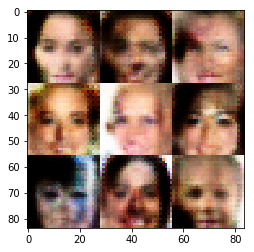

Epoch 1/1, Discriminator Loss: 2.2848, Generator Loss: 0.1408
Epoch 1/1, Discriminator Loss: 0.3891, Generator Loss: 1.8605
Epoch 1/1, Discriminator Loss: 0.2017, Generator Loss: 3.0221
Epoch 1/1, Discriminator Loss: 2.3887, Generator Loss: 3.0859


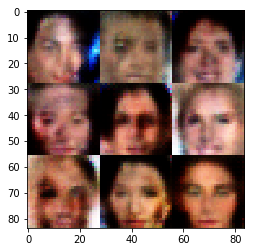

Epoch 1/1, Discriminator Loss: 0.7567, Generator Loss: 0.8878
Epoch 1/1, Discriminator Loss: 1.8614, Generator Loss: 0.2185
Epoch 1/1, Discriminator Loss: 1.0333, Generator Loss: 2.1567
Epoch 1/1, Discriminator Loss: 0.2074, Generator Loss: 4.1416


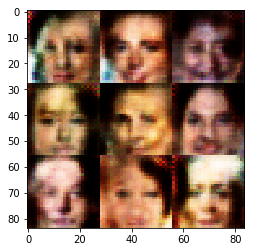

Epoch 1/1, Discriminator Loss: 0.6595, Generator Loss: 1.0032
Epoch 1/1, Discriminator Loss: 0.3779, Generator Loss: 1.6741
Epoch 1/1, Discriminator Loss: 0.1789, Generator Loss: 2.9012
Epoch 1/1, Discriminator Loss: 0.4630, Generator Loss: 1.2275


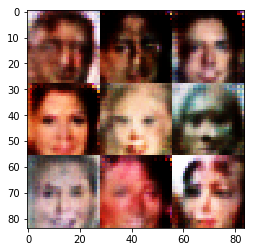

Epoch 1/1, Discriminator Loss: 0.1819, Generator Loss: 2.6233
Epoch 1/1, Discriminator Loss: 0.3907, Generator Loss: 1.7163
Epoch 1/1, Discriminator Loss: 0.2994, Generator Loss: 4.9966
Epoch 1/1, Discriminator Loss: 0.2344, Generator Loss: 2.0511


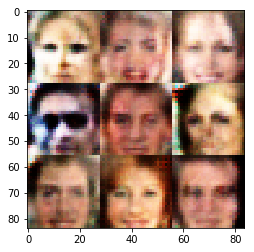

Epoch 1/1, Discriminator Loss: 0.4722, Generator Loss: 1.2766
Epoch 1/1, Discriminator Loss: 0.5301, Generator Loss: 2.0736
Epoch 1/1, Discriminator Loss: 0.2522, Generator Loss: 3.3359
Epoch 1/1, Discriminator Loss: 0.0707, Generator Loss: 4.7416


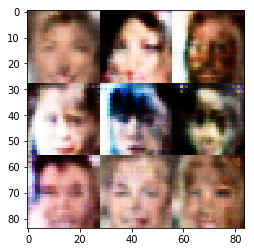

Epoch 1/1, Discriminator Loss: 0.2160, Generator Loss: 5.2512
Epoch 1/1, Discriminator Loss: 1.2341, Generator Loss: 0.8612
Epoch 1/1, Discriminator Loss: 0.3657, Generator Loss: 1.5488
Epoch 1/1, Discriminator Loss: 0.2946, Generator Loss: 2.3987


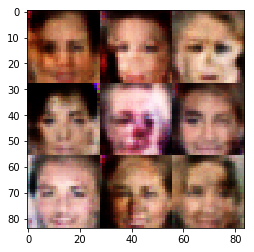

Epoch 1/1, Discriminator Loss: 0.4039, Generator Loss: 1.4871
Epoch 1/1, Discriminator Loss: 0.6563, Generator Loss: 1.7376
Epoch 1/1, Discriminator Loss: 0.1694, Generator Loss: 4.0764
Epoch 1/1, Discriminator Loss: 1.0226, Generator Loss: 0.5911


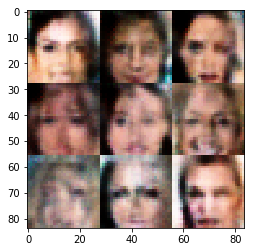

Epoch 1/1, Discriminator Loss: 0.2804, Generator Loss: 2.0089
Epoch 1/1, Discriminator Loss: 0.2206, Generator Loss: 3.1135
Epoch 1/1, Discriminator Loss: 0.6067, Generator Loss: 1.2573
Epoch 1/1, Discriminator Loss: 1.3173, Generator Loss: 0.4320


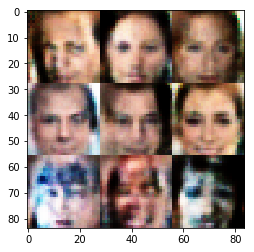

Epoch 1/1, Discriminator Loss: 0.6452, Generator Loss: 1.4792
Epoch 1/1, Discriminator Loss: 2.3408, Generator Loss: 3.8642
Epoch 1/1, Discriminator Loss: 0.4531, Generator Loss: 1.2628
Epoch 1/1, Discriminator Loss: 1.2490, Generator Loss: 0.4598


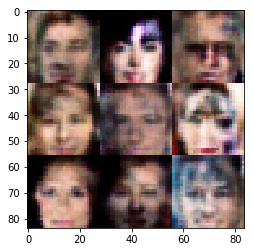

Epoch 1/1, Discriminator Loss: 0.8759, Generator Loss: 0.6985
Epoch 1/1, Discriminator Loss: 0.7937, Generator Loss: 1.0230
Epoch 1/1, Discriminator Loss: 0.1947, Generator Loss: 2.5616
Epoch 1/1, Discriminator Loss: 0.8267, Generator Loss: 0.9839


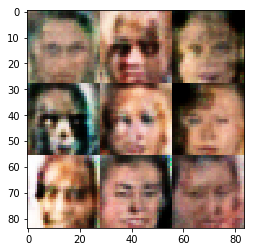

Epoch 1/1, Discriminator Loss: 0.3001, Generator Loss: 2.6329
Epoch 1/1, Discriminator Loss: 0.1650, Generator Loss: 3.4367
Epoch 1/1, Discriminator Loss: 0.2043, Generator Loss: 2.4652
Epoch 1/1, Discriminator Loss: 1.1454, Generator Loss: 0.9888


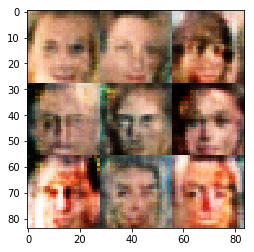

Epoch 1/1, Discriminator Loss: 0.3313, Generator Loss: 2.0573
Epoch 1/1, Discriminator Loss: 0.5451, Generator Loss: 1.2142
Epoch 1/1, Discriminator Loss: 0.1744, Generator Loss: 2.8907
Epoch 1/1, Discriminator Loss: 0.5380, Generator Loss: 1.3681


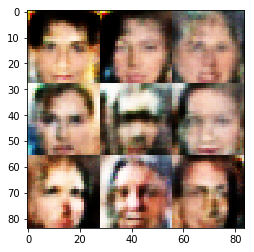

Epoch 1/1, Discriminator Loss: 0.1501, Generator Loss: 2.5797
Epoch 1/1, Discriminator Loss: 0.3860, Generator Loss: 4.7621
Epoch 1/1, Discriminator Loss: 0.9533, Generator Loss: 0.8328
Epoch 1/1, Discriminator Loss: 0.7133, Generator Loss: 0.9270


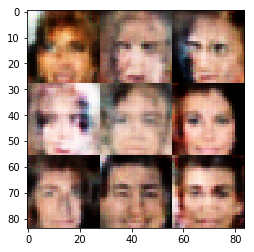

Epoch 1/1, Discriminator Loss: 0.3309, Generator Loss: 3.1386
Epoch 1/1, Discriminator Loss: 0.1443, Generator Loss: 2.6186
Epoch 1/1, Discriminator Loss: 0.5029, Generator Loss: 2.0602
Epoch 1/1, Discriminator Loss: 0.8229, Generator Loss: 0.7007


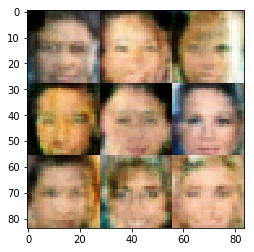

Epoch 1/1, Discriminator Loss: 0.3842, Generator Loss: 2.2998
Epoch 1/1, Discriminator Loss: 0.3751, Generator Loss: 2.6405
Epoch 1/1, Discriminator Loss: 0.1713, Generator Loss: 2.9490
Epoch 1/1, Discriminator Loss: 0.5585, Generator Loss: 1.2135


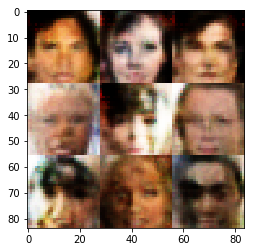

Epoch 1/1, Discriminator Loss: 0.8556, Generator Loss: 2.4959
Epoch 1/1, Discriminator Loss: 0.2243, Generator Loss: 2.1414
Epoch 1/1, Discriminator Loss: 0.0941, Generator Loss: 3.9512
Epoch 1/1, Discriminator Loss: 0.8014, Generator Loss: 1.7425


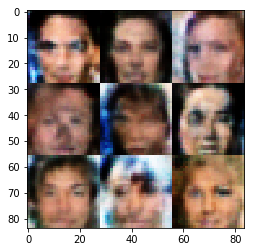

Epoch 1/1, Discriminator Loss: 1.0649, Generator Loss: 0.6730
Epoch 1/1, Discriminator Loss: 0.2061, Generator Loss: 2.7450
Epoch 1/1, Discriminator Loss: 0.0621, Generator Loss: 4.2058
Epoch 1/1, Discriminator Loss: 0.5261, Generator Loss: 1.2137


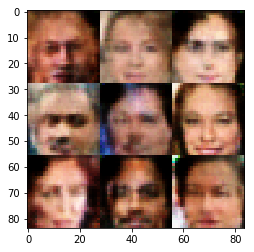

Epoch 1/1, Discriminator Loss: 0.5099, Generator Loss: 1.6842
Epoch 1/1, Discriminator Loss: 0.2203, Generator Loss: 1.9278
Epoch 1/1, Discriminator Loss: 0.1873, Generator Loss: 3.9412
Epoch 1/1, Discriminator Loss: 0.3702, Generator Loss: 1.9641


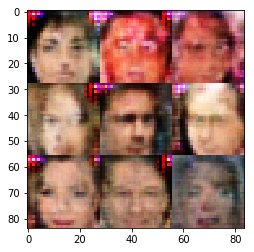

Epoch 1/1, Discriminator Loss: 0.6261, Generator Loss: 1.3170
Epoch 1/1, Discriminator Loss: 0.4795, Generator Loss: 4.5793
Epoch 1/1, Discriminator Loss: 0.3905, Generator Loss: 3.9297
Epoch 1/1, Discriminator Loss: 1.2522, Generator Loss: 4.2731


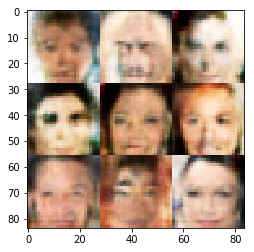

Epoch 1/1, Discriminator Loss: 0.4423, Generator Loss: 2.0526
Epoch 1/1, Discriminator Loss: 0.3930, Generator Loss: 1.4070
Epoch 1/1, Discriminator Loss: 0.2504, Generator Loss: 1.9664
Epoch 1/1, Discriminator Loss: 1.8127, Generator Loss: 0.2292


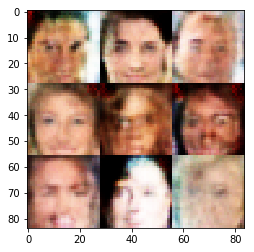

Epoch 1/1, Discriminator Loss: 0.5899, Generator Loss: 1.0372
Epoch 1/1, Discriminator Loss: 0.0858, Generator Loss: 4.7366
Epoch 1/1, Discriminator Loss: 0.1009, Generator Loss: 3.2989
Epoch 1/1, Discriminator Loss: 0.0998, Generator Loss: 4.5785


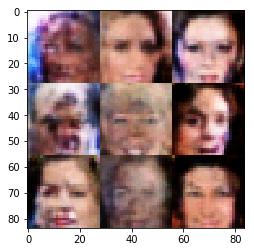

Epoch 1/1, Discriminator Loss: 0.4633, Generator Loss: 1.5649
Epoch 1/1, Discriminator Loss: 0.0937, Generator Loss: 7.0590
Result after training:


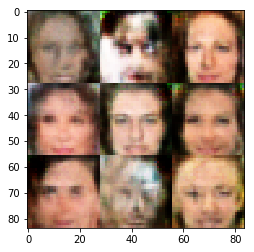

In [91]:
batch_size = 64
z_dim = 128
learning_rate = 0.0001
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.